In [85]:
import pandas as pd
import numpy as np

nba_df = pd.read_csv("../Data/gamesWithInfo2012-13.csv")
for year in range(2013,2021):
    df = pd.read_csv(f"../Data/gamesWithInfo{year}-{str(year+1)[2:]}.csv")
    nba_df = nba_df.append(df)

#nba_df.to_csv("../Data/NBA_GAMES_2012-2021.csv", index=False)


In [95]:

team_odds_lookup_dict = {
    "Washington Wizards": "Washington",
    "San Antonio Spurs": "SanAntonio",
    "Toronto Raptors": "Toronto",
    "Chicago Bulls" : "Chicago",
    "Boston Celtics": "Boston", 
    "New York Knicks": "NewYork",
    "Los Angeles Clippers": "LAClippers",
    "LA Clippers": "LAClippers",
    "Phoenix Suns": "Phoenix",
    "Indiana Pacers": "Indiana",
    "Cleveland Cavaliers": "Cleveland",
    "New Orleans Pelicans": "NewOrleans",
    "New Orleans Hornets": "NewOrleans",
    "Houston Rockets": "Houston",
    "Philadelphia 76ers": "Philadelphia",
    "Detroit Pistons": "Detroit",
    "Sacramento Kings": "Sacramento",
    "Utah Jazz": "Utah",
    "Miami Heat": "Miami",
    "Milwaukee Bucks": "Milwaukee",
    "Orlando Magic": "Orlando",
    "Atlanta Hawks": "Atlanta",
    "Charlotte Hornets": "Charlotte",
    "Charlotte Bobcats": "Charlotte",
    "Los Angeles Lakers": "LALakers",
    "Portland Trail Blazers": "Portland",
    "Dallas Mavericks": "Dallas",
    "Minnesota Timberwolves": "Minnesota",
    "Brooklyn Nets": "Brooklyn",
    "Memphis Grizzlies": "Memphis",
    "Golden State Warriors": "GoldenState",
    "Oklahoma City Thunder": "OklahomaCity",
    "Denver Nuggets": "Denver"
}
#nba_df = pd.read_csv("../Data/COMBINEDgamesWithInfo2016-19.csv")
odds_df = pd.read_excel("../Odds/nba odds 2010-11.xlsx", engine='openpyxl')
change_idx = np.where(odds_df["Date"] == 101)[0][0]
odds_df['year'] = 2010
odds_df['year'].iloc[change_idx:] = 2011


odds_df['Date'] = pd.to_datetime(odds_df['Date'], format='%m%d')
odds_df['year'] = np.where(odds_df["Date"].dt.month < 7, 2011,2010)
odds_df['year'] = 2010
for year in range(2011,2021):
    df = pd.read_excel(f"../Odds/nba odds {year}-{str(year+1)[2:]}.xlsx", engine='openpyxl')
    change_idx = np.where(df["Date"] == 101)[0][0]
    df['year'] = year
    df['year'].iloc[change_idx:] = year+1
    df['season'] = year
    odds_df = odds_df.append(df)



# Only have games from 2016,2017,2018 seasons
odds_df = odds_df[(odds_df['season'] > 2011) & (odds_df['season'] < 2021)]
odds_df.head()

,1st,2H,2nd,3rd,4th,Close,Date,Final,ML,Open,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,VH,season,year
0,24.0,0.5,15.0,23.0,22.0,190.5,1030,84.0,210.0,191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V,2012.0,2012
1,27.0,94.5,23.0,24.0,20.0,6,1030,94.0,-250.0,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,2012.0,2012
2,25.0,95,29.0,22.0,31.0,187.5,1030,107.0,240.0,184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V,2012.0,2012
3,31.0,1,31.0,31.0,27.0,6.5,1030,120.0,-280.0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,2012.0,2012
4,25.0,94,23.0,26.0,25.0,186.5,1030,99.0,400.0,187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V,2012.0,2012


In [96]:
from datetime import datetime
away_odds_list = []
home_odds_list = []
for idx, row in nba_df.iterrows():

    home = row["Home"]
    away = row["Away"]
    date = datetime.strptime(row["Date"], "%m/%d/%Y")
    away_mapping = team_odds_lookup_dict[away]
    home_mapping = team_odds_lookup_dict[home]
    odds_away_row = odds_df[ (odds_df["Date"] == int(f"{date.month}{str(date.day).zfill(2)}")) & (odds_df["Team"] == away_mapping) & (odds_df['year'] == int(date.year))]
    away_odds = 0
    if odds_away_row.empty:
        print(f"Missing Away {date}: {away_mapping} @ {home_mapping}")
    else:
        away_odds = odds_away_row["ML"].iloc[0]
        if not isinstance(away_odds, float):
            away_odds = 0
    odds_home_row = odds_df[ (odds_df["Date"] == int(f"{date.month}{str(date.day).zfill(2)}")) & (odds_df["Team"] == home_mapping) & (odds_df['year'] == int(date.year))]
    home_odds = 0
    if odds_home_row.empty:
        print(f"Missing Home {date}: {away_mapping} @ {home_mapping}")
    else:
        home_odds = odds_home_row["ML"].iloc[0]
        if not isinstance(home_odds, float):
            home_odds = 0
    
    away_odds_list.append(int(away_odds))
    home_odds_list.append(int(home_odds))

Missing Away 2013-04-16 00:00:00: Indiana @ Boston
Missing Home 2013-04-16 00:00:00: Indiana @ Boston
Missing Away 2016-01-24 00:00:00: OklahomaCity @ Brooklyn
Missing Away 2016-01-24 00:00:00: LAClippers @ Toronto


In [97]:
nba_df["away_odds"] = away_odds_list
nba_df["home_odds"] = home_odds_list
nba_df[["Date", "Away", "Home", "away_odds", "home_odds"]].head(25)
nba_df.to_csv("../Odds/NBA_GAMES_W_ODDS.csv", index=False)

In [104]:
from sklearn.linear_model import LogisticRegression

cutoff = datetime(2017, 7, 1)
nba_df["Date"] = pd.to_datetime(nba_df['Date'], format='%m/%d/%Y')
train_df = nba_df[nba_df["Date"] < cutoff ]
display(len(train_df))
test_df = nba_df[nba_df["Date"] >= cutoff]
display(len(test_df))
# Update if new stats are added
featureColumns = ['W_PCT', 'REB', 'TOV', 'PLUS_MINUS', 'OFF_RATING', 'DEF_RATING', 'TS_PCT']

X_train = train_df[featureColumns] # Features
Y_train = train_df.Result  # Target Variable

X_test = test_df[featureColumns] # Features
Y_test = test_df.Result  # Target Variable

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)  # Fits model with data

Y_pred = logreg.predict(X_test)

5769

3990

/Users/kevin/repos/NBA-Predict/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [127]:
from sklearn import metrics
def get_bet_results(Y_pred, Y_test, test_df):
    profits = []
    dates = []
    for idx,y in enumerate(Y_test):
        odds = test_df.iloc[idx]['home_odds'] if Y_pred[idx] else test_df.iloc[idx]['away_odds']
        date = test_df.iloc[idx]['Date']
        profit = 0
        # Try skipping long odds
        if odds < -200:
             continue
        if y - Y_pred[idx] == 0:
            profit = odds/100 if odds > 0 else -100/odds
        else:
            profit = -1
        profits.append(profit)
        dates.append(date)
    profit_cum = np.cumsum(profits)  # returns a numpy.ndarray
    data = {
        "dates": dates,
        "profit": profits
    }
    agg = pd.DataFrame(data).groupby(['dates']).agg({"profit":"sum","dates":"count"}).rename({"dates":"dates_count"}, axis=1)
    agg["cumulative"] = np.cumsum(agg["profit"])
    agg.reset_index(level=0, inplace=True)
    agg["dates"] = pd.to_datetime(agg['dates'], format="%Y%m%d")
    agg.plot(x="dates", y="cumulative")
    display("Accuracy:",metrics.accuracy_score(Y_pred, Y_test))
    return agg

'Accuracy:'

0.6541353383458647

,dates,profit,dates_count,cumulative
0,2017-11-17,0.290741,5,0.290741
1,2017-11-18,0.512821,1,0.803561
2,2017-11-19,-0.310345,2,0.493216
3,2017-11-20,1.047619,7,1.540835
4,2017-11-22,-4.361204,8,-2.820369
...,...,...,...,...
514,2021-05-11,-0.419804,6,-65.775782
515,2021-05-12,-0.500000,2,-66.275782
516,2021-05-13,0.983516,4,-65.292266
517,2021-05-14,1.458333,2,-63.833932


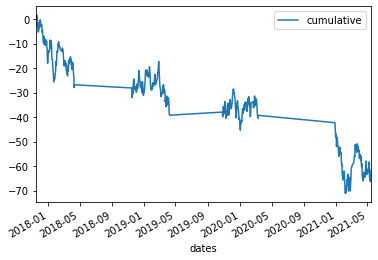

In [128]:
get_bet_results(Y_pred, Y_test, test_df)


'Accuracy:'

0.6521303258145363

,dates,profit,dates_count,cumulative
0,2017-11-17,0.290741,5,0.290741
1,2017-11-18,0.512821,1,0.803561
2,2017-11-19,-0.310345,2,0.493216
3,2017-11-20,1.633333,7,2.126550
4,2017-11-22,-2.694537,8,-0.567988
...,...,...,...,...
515,2021-05-11,-2.769804,6,-75.970902
516,2021-05-12,-0.500000,2,-76.470902
517,2021-05-13,0.983516,4,-75.487385
518,2021-05-14,1.458333,2,-74.029052


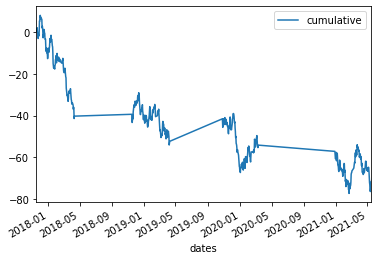

In [130]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1500, max_depth=4, bootstrap=True, min_samples_split=2, min_samples_leaf=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, Y_train)
Y_pred_clf = clf.predict(X_test)
get_bet_results(Y_pred_clf, Y_test, test_df)

/Users/kevin/repos/NBA-Predict/venv/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


'Accuracy:'

0.6132832080200501

,dates,profit,dates_count,cumulative
0,2017-11-17,3.474074,7,3.474074
1,2017-11-18,-0.487179,2,2.986895
2,2017-11-19,-0.310345,2,2.676550
3,2017-11-20,-0.266667,9,2.409883
4,2017-11-22,-1.123562,9,1.286321
...,...,...,...,...
521,2021-05-11,-2.769804,6,-73.639100
522,2021-05-12,-0.500000,2,-74.139100
523,2021-05-13,-0.016484,5,-74.155584
524,2021-05-14,1.458333,2,-72.697250


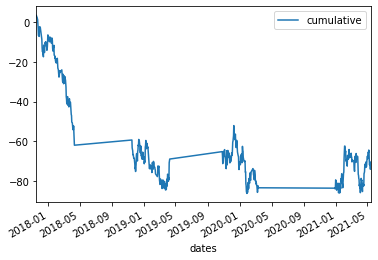

In [131]:
# XGBoost
#!pip install xgboost
from xgboost import XGBClassifier
#0.011208547084229371, 610, 10, 1.2333283160680772, 0.4868777594207297, 0.6163856702151521, 0.5453032172664104
XGBooster = XGBClassifier(
          #learning_rate = 0.0015,
            n_estimators = 500,
           max_depth = 15,
          # min_child_weight=1.2333283160680772,
            #gamma=0.4868777594207297,       
            random_state = 499,
           #  subsample=0.6163856702151521,
           #colsample_bytree=0.5453032172664104,
                     n_jobs = -1,
                verbosity=1)
XGBooster.fit(X_train, Y_train, 
#eval_set=[(X2_val, Y2_val)],
eval_metric=["logloss","error"], 
#early_stopping_rounds=500, 
verbose=1 )

Y_pred_xgb = XGBooster.predict(X_test)
get_bet_results(Y_pred_xgb, Y_test, test_df)

'Accuracy:'

0.5656641604010025

,dates,profit,dates_count,cumulative
0,2017-11-17,5.774074,8,5.774074
1,2017-11-18,-0.387179,5,5.386895
2,2017-11-19,1.389655,3,6.776550
3,2017-11-20,-2.885714,9,3.890835
4,2017-11-22,5.396338,9,9.287173
...,...,...,...,...
525,2021-05-11,0.439655,9,-82.238753
526,2021-05-12,1.600000,3,-80.638753
527,2021-05-13,-0.930769,6,-81.569522
528,2021-05-14,1.958333,5,-79.611189


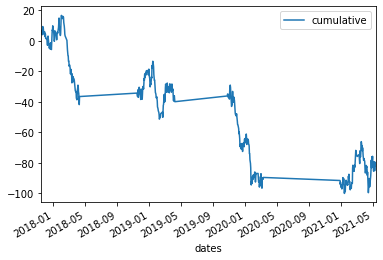

In [132]:
# Always pick home
Y_pred_home = np.ones(len(Y_test))
get_bet_results(Y_pred_home, Y_test, test_df)

'Accuracy:'

0.325062656641604

,dates,profit,dates_count,cumulative
0,2017-11-17,3.850000,11,3.850000
1,2017-11-18,-0.700000,7,3.150000
2,2017-11-19,2.600000,6,5.750000
3,2017-11-20,-1.800000,11,3.950000
4,2017-11-21,-1.000000,1,2.950000
...,...,...,...,...
532,2021-05-11,-3.250000,11,-52.409784
533,2021-05-12,-0.947619,6,-53.357403
534,2021-05-13,-9.000000,9,-62.357403
535,2021-05-14,-4.500000,8,-66.857403


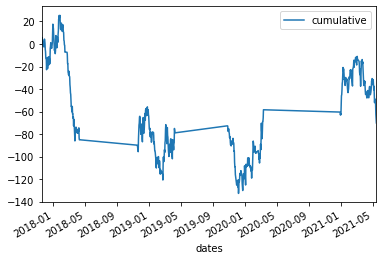

In [133]:
# Always pick underdog
Y_pred_underdog = np.where(test_df["home_odds"] > test_df["away_odds"], 1, 0)
get_bet_results(Y_pred_underdog, Y_test, test_df)

'Accuracy:'

0.674937343358396

,dates,profit,dates_count,cumulative
0,2017-11-17,0.074074,5,0.074074
1,2017-11-18,0.512821,1,0.586895
2,2017-11-19,-0.310345,2,0.276550
3,2017-11-20,-1.711640,7,-1.435090
4,2017-11-22,2.382235,8,0.947145
...,...,...,...,...
512,2021-05-11,0.063529,5,-99.407494
513,2021-05-12,-0.500000,2,-99.907494
514,2021-05-13,2.783516,4,-97.123978
515,2021-05-14,1.458333,2,-95.665645


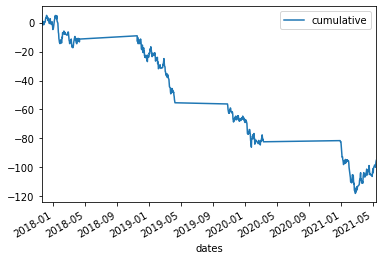

In [134]:
# Always pick favorite
Y_pred_underdog = np.where(test_df["home_odds"] < test_df["away_odds"], 1, 0)
get_bet_results(Y_pred_underdog, Y_test, test_df)